## ML - Fitting a scikit-learn regressor on EC2
### Milestone 3 - Task 3
### DSCI 525 - Group 10


In [1]:
import re
import os
import glob
import zipfile
import requests
from urllib.request import urlretrieve
import json
import pandas as pd
import numpy as np

# Modelling
from joblib import dump, load
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# Visuals
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 8, 'axes.labelweight': 'bold', 'figure.figsize': (8,6)})

/opt/tljh/user/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.4) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


### Overview

In our previous step (notebooks/02-ml_preprocessing.ipynb) we have read  in multiple weather model forecasts for Australia from parquet files, trim to Sydney forecasts and then join on actual observed rainfall data. We aggregated to *mean* daily rainfall from the models to compare to actuals. The final data frame has a separate column for each weather model to be used for machine learning modelling of the actual rainfall in Sydney. The target column is `observed_rainfall`.

We will read in this dataset from our S3 bucket, drop NA's and do a 80/20% train/test split. We will then compare RMSE error from the raw weather model predictions vs. an ensemble machine learning method.

In [2]:
# INPUTS ------------------------------------------
# path_to_input_datasets = "/srv/data/my_shared_data_folder/"
path_to_input = "s3://mds-s3-student71/output/"

# path_to_output = "/srv/data/my_shared_data_folder/"
path_to_output = "s3://mds-s3-student71/output/"



In [3]:
df_modelling = pd.read_csv(os.path.join(path_to_input, "ml_data_SYD.csv"), index_col=0, parse_dates=True)

model_names = list(set(df_modelling.columns).difference("observed_rainfall"))


In [4]:
df_modelling.head()

,ACCESS-CM2,ACCESS-ESM1-5,AWI-ESM-1-1-LR,BCC-CSM2-MR,BCC-ESM1,CMCC-CM2-HR4,CMCC-CM2-SR5,CMCC-ESM2,CanESM5,EC-Earth3-Veg-LR,...,MPI-ESM-1-2-HAM,MPI-ESM1-2-HR,MPI-ESM1-2-LR,MRI-ESM2-0,NESM3,NorESM2-LM,NorESM2-MM,SAM0-UNICON,TaiESM1,observed_rainfall
time,,,,,,,,,,,,,,,,,,,,,
1889-01-01,0.040427,1.814552,35.579336,4.268112e+00,1.107466e-03,11.410537,3.322009e-08,2.668800,1.321215,1.515293,...,4.244226e-13,1.390174e-13,6.537884e-05,3.445495e-06,1.576096e+01,4.759651e-05,2.451075,0.221324,2.257933,0.006612
1889-01-02,0.073777,0.303965,4.596520,1.190141e+00,1.015323e-04,4.014984,1.312700e+00,0.946211,2.788724,4.771375,...,4.409552e+00,1.222283e-01,1.049131e-13,4.791993e-09,3.675510e-01,4.350863e-01,0.477231,3.757179,2.287381,0.090422
1889-01-03,0.232656,0.019976,5.927467,1.003845e-09,1.760345e-05,9.660565,9.103720e+00,0.431999,0.003672,4.233980,...,2.269300e-01,3.762301e-01,9.758706e-14,6.912302e-01,1.562869e-01,9.561101e+00,0.023083,0.253357,1.199909,1.401452
1889-01-04,0.911319,13.623777,8.029624,8.225225e-02,1.808932e-01,3.951528,1.317160e+01,0.368693,0.013578,15.252495,...,2.344586e-02,4.214019e-01,7.060915e-03,3.835721e-02,2.472226e-07,5.301038e-01,0.002699,2.185454,2.106737,14.869798
1889-01-05,0.698013,0.021048,2.132686,2.496841e+00,4.708019e-09,2.766362,1.822940e+01,0.339267,0.002468,11.920356,...,4.270161e-13,1.879692e-01,4.504985e+00,3.506923e-07,1.949792e-13,1.460928e-10,0.001026,2.766507,1.763335,0.467628


### Data splitting and EDA

In [5]:
df_train, df_test = train_test_split(df_modelling.dropna(), test_size=0.2, random_state=123)

In [6]:
print(f"Train set size: {df_train.shape}")
print(f"Test set size: {df_test.shape}")

Train set size: (36791, 26)
Test set size: (9198, 26)


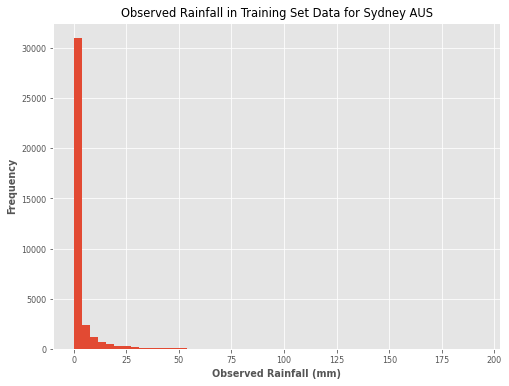

In [7]:
df_train["observed_rainfall"].plot(kind="hist",
                                   title="Observed Rainfall in Training Set Data for Sydney AUS",
                                  bins=50);
plt.xlabel("Observed Rainfall (mm)");

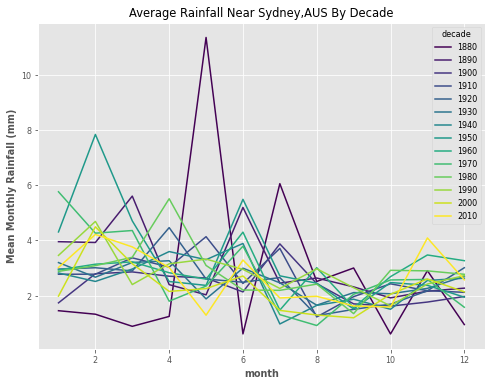

In [27]:
(df_train
 .assign(month = lambda x:x.index.month, 
        decade = lambda x: 10*(x.index.year // 10))
 .groupby(["decade","month"])
 .mean()
 .reset_index()
 .pivot(index="month", columns="decade", values="observed_rainfall")
 .plot(kind="line", cmap="viridis", title="Average Rainfall Near Sydney,AUS By Decade", ylabel="Mean Monthly Rainfall (mm)")
);

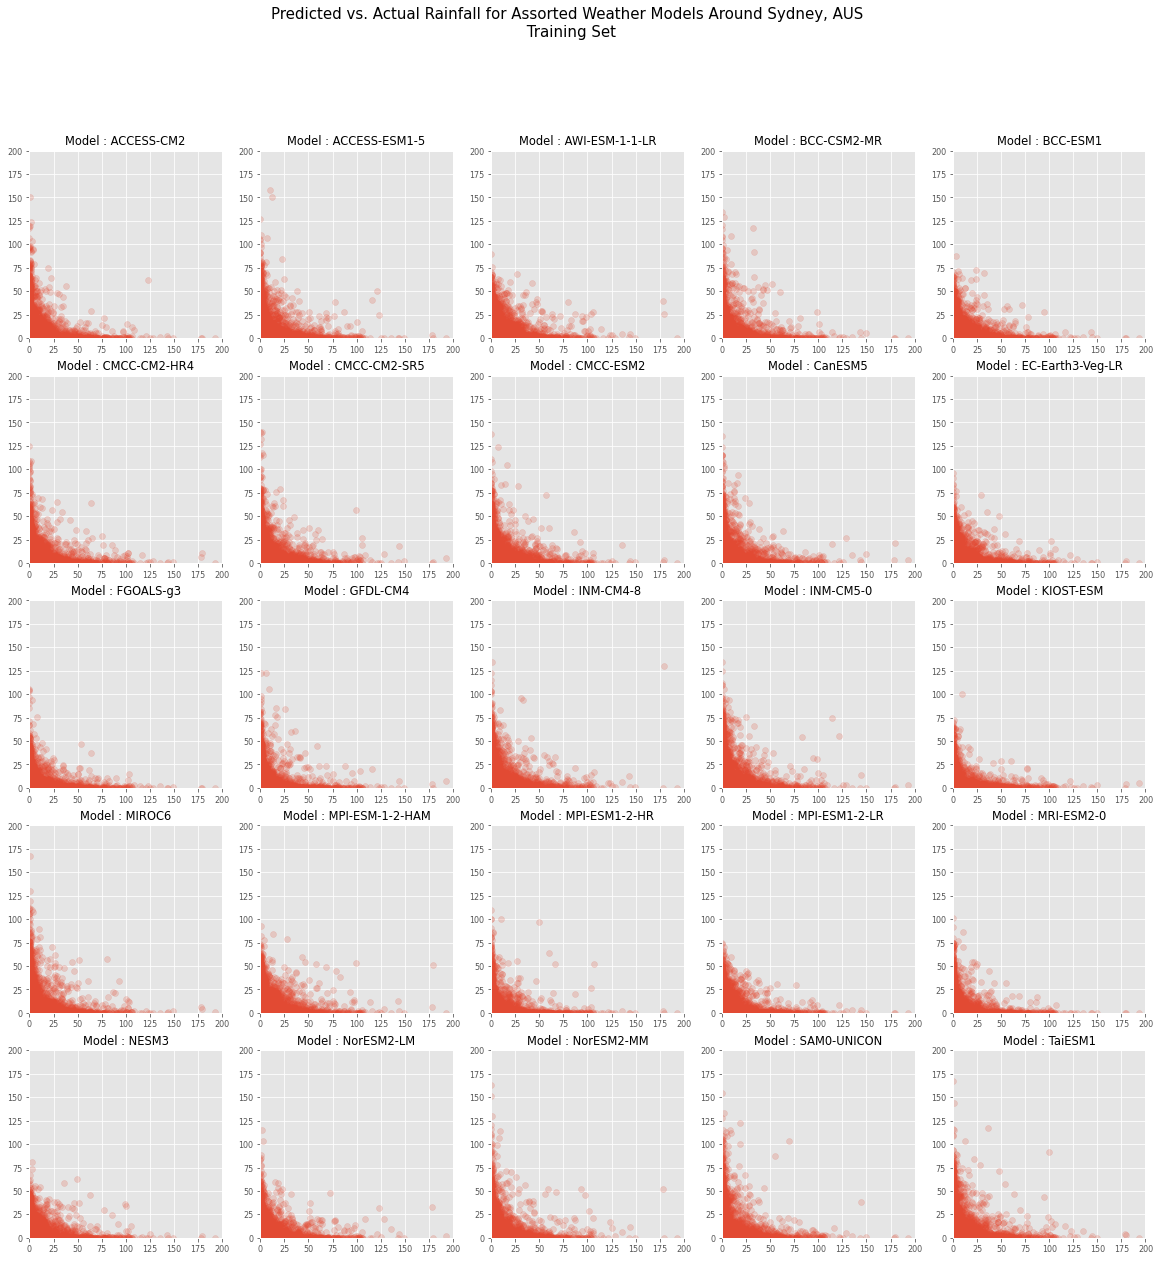

In [28]:
# Quick scatter matrix of predicted vs. actual for every weather model
fig,ax = plt.subplots(nrows=5, ncols=5, figsize=(20,20))
fig.suptitle("Predicted vs. Actual Rainfall for Assorted Weather Models Around Sydney, AUS \n Training Set", fontsize=15)
# fig.get_title().set_fontsize(15)

rmse_train_dict = {}

for i in range(0,25):
    ax[i//5, i % 5].scatter(df_train.iloc[:,25], df_train.iloc[:,i], alpha=0.2)
    ax[i//5, i % 5].set_title(f"Model : {df_train.columns[i]}")
    ax[i//5, i % 5].set_xlim([0, 200])
    ax[i//5, i % 5].set_ylim([0, 200])
    
    rmse_train_dict[df_train.columns[i]] = np.sqrt(mean_squared_error(df_train.iloc[:,25],df_train.iloc[:,i]))

We can see there isn't a clear correlation between the underlying model predictions and the rainfall actuals. Let's hope we can clean this up.

### Model Building and Cross Validation on Training Set

In [ ]:
%%time

X, y = df_train.loc[:,model_names].values, df_train["observed_rainfall"].values

param_grid = {"n_estimators":[50,100,150],
             "max_depth": [3,4,5]}

grid_searcher = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                             n_jobs=-1, 
                             param_grid=param_grid, 
                             scoring="neg_mean_squared_error", 
                             cv=3, refit=True, error_score="raise")

grid_searcher.fit(X,y)


In [ ]:
(pd.DataFrame(grid_searcher.cv_results_)
 .sort_values("mean_test_score", ascending=False)
 [["mean_test_score","params"]]
 .assign(mean_squared_error = lambda x: -x.mean_test_score)
 .drop(columns="mean_test_score")
 .style
 .background_gradient(subset="mean_squared_error")
 .set_caption("Grid Search Results Summary")
)

We'll compare the CV root mean squared error against the other model's root mean squared error score. Otherwise we'd be inflating our estimate of model performance when it was fit on the train set.

We can see that our optimal parameters are `max_depth`=5, `n_estimators`=100, which matches from our work with PySpark.

In [ ]:
rmse_train_dict["rf_ensemble"] = np.sqrt(-pd.DataFrame(grid_searcher.cv_results_)["mean_test_score"].max())

In [ ]:
(pd.DataFrame.from_dict(rmse_train_dict,orient="index", columns=["RMSE"])
 .sort_values("RMSE")
 .style
 .background_gradient()
 .set_caption("Train Set RMSE - CV for Random Forest Model")
)

### Evaluation on Test Set

In [ ]:
fig,ax = plt.subplots(nrows=5, ncols=5, figsize=(20,20))
fig.suptitle("Predicted vs. Actual Rainfall for Assorted Weather Models Around Sydney, AUS \n Test Set", fontsize=15)

rmse_test_dict = {}

for i in range(0,25):
    ax[i//5, i % 5].scatter(df_test.iloc[:,25], df_test.iloc[:,i], alpha=0.2)
    ax[i//5, i % 5].set_title(f"Model : {df_train.columns[i]}")
    ax[i//5, i % 5].set_xlim([0, 200])
    ax[i//5, i % 5].set_ylim([0, 200])
    
    rmse_test_dict[df_test.columns[i]] = np.sqrt(mean_squared_error(df_test.iloc[:,25],df_test.iloc[:,i]))

In [ ]:
X_test,y_test = df_test.loc[:,model_names].values, df_test["observed_rainfall"].values
y_test_pred = grid_searcher.best_estimator_.predict(X_test)

rmse_test_dict["rf_ensemble"] = np.sqrt(mean_squared_error(y_test,y_test_pred))

In [ ]:
train_results = pd.DataFrame.from_dict(rmse_train_dict,orient="index", columns=["RMSE"])
test_results = pd.DataFrame.from_dict(rmse_test_dict,orient="index", columns=["RMSE_test"])
total_results = train_results.merge(test_results, left_index=True, right_index=True).sort_values("RMSE_test")
    
fig,ax = plt.subplots(figsize=(15,8))
(total_results
 .plot(ax=ax, title="RMSE Comparison between ML Model Ensemble and Weather Models", 
       ylabel="Root Mean Squared Error (mm rain)",
      xlabel="Model")
)
ax.set_xticks(np.arange(len(total_results.index)));
ax.set_xticklabels(total_results.index,rotation=45);

                                


In [ ]:
df_test["rf_predicted"] = y_test_pred

df_test.plot(kind="scatter", x="observed_rainfall", y="rf_predicted", 
             title="Predicted vs. Actual Rainfall for Sydney AUS \n Random Forest Ensemble of Weather Models",
            xlabel="Observed Rainfall (mm)", ylabel="Predicted Rainfall (mm)");


### Model Persistence

In [ ]:
from joblib import dump
dump(grid_searcher.best_estimator_, "model.joblib")